In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import datetime
import geopandas
import logging
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib import colors

%matplotlib inline
import numpy as np
import os
import pandas as pd
import requests
import shapefile
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

In [56]:
map_crs = ccrs.LambertConformal(central_latitude=35, central_longitude=-100)
cat_plot_colors = {"TSTM": 'palegreen',
                   "MRGL": 'green',
                   "SLGT": 'yellow',
                   "ENH" : 'goldenrod',
                   "MDT" : 'red',
                   "HIGH": 'magenta'}

idate = pd.to_datetime("202107282000")
#idate = datetime.datetime.now()

In [57]:
# Got from iowa e m https://mesonet.agron.iastate.edu/request/gis/spc_outlooks.phtml

if idate < pd.to_datetime("20221128"):
    ifile = "outlooks_202201010000_202211280000"
    if idate <= pd.to_datetime("20220101"):
        ifile = "outlooks_202101010000_202201010000"
    if idate <= pd.to_datetime("20210101"):
        ifile = "outlooks_201801010000_202101010000"
    gdf = geopandas.read_file(ifile)
    column = "THRESHOLD"
    subset = gdf["DAY"].eq(1) & gdf["CATEGORY"].eq("CATEGORICAL") # & gdf["ISSUE"].eq(idate.strftime("%Y%m%d%H%M"))
    gdf = gdf[subset]
    gdf = gdf[gdf.ISSUE == idate.strftime("%Y%m%d%H%M")]
else:
    ifile = requests.get("https://www.spc.noaa.gov/products/outlook/day1otlk_cat.nolyr.geojson")
    gdf = geopandas.GeoDataFrame.from_features(ifile.json())
    gdf = gdf.set_crs("epsg:4269")
    column = "LABEL"
gdf

,ISSUE,EXPIRE,PRODISS,TYPE,DAY,THRESHOLD,CATEGORY,CYCLE,geometry
8974,202107282000,202107291200,202107282000,C,1,SLGT,CATEGORICAL,20,"MULTIPOLYGON (((-75.26300 37.54800, -75.35600 ..."
8982,202107282000,202107291200,202107282000,C,1,MRGL,CATEGORICAL,20,"POLYGON ((-95.87400 48.99800, -95.10600 48.998..."
8988,202107282000,202107291200,202107282000,C,1,MDT,CATEGORICAL,20,"POLYGON ((-85.11000 42.28000, -85.49000 41.770..."
8989,202107282000,202107291200,202107282000,C,1,ENH,CATEGORICAL,20,"POLYGON ((-87.57000 41.79000, -89.70000 42.710..."
8990,202107282000,202107291200,202107282000,C,1,TSTM,CATEGORICAL,20,"POLYGON ((-95.87400 48.99800, -95.10600 48.998..."


In [58]:
cat = "TSTM"
for subtract in ["MRGL", "SLGT", "ENH", "MDT", "HIGH"]:
    logging.info(f"subtracting {subtract}")
    gdf.loc[gdf[column].eq(cat)] = gdf.loc[gdf[column].eq(cat)].overlay(gdf[gdf[column].eq(subtract)],
                                                                              how="difference").values
    cat = subtract   
gdf.explore(legend=True, column=column, categories=["TSTM","MRGL","SLGT","ENH","MDT","HIGH"],
           cmap=colors.ListedColormap(list(cat_plot_colors.values())))

In [59]:
agdf = [geopandas.read_file(x) for x in [
    "outlooks_202201010000_202211280000",
    "outlooks_202101010000_202201010000",
    "outlooks_201801010000_202101010000"]]
agdf = pd.concat(agdf)

In [60]:
risk="MDT"
ih = agdf["THRESHOLD"] == risk
print(f"{sum(ih)} {risk} risk days")
agdf.loc[ih].sort_values("ISSUE").ISSUE.unique()

263 MDT risk days


array(['201803191630', '201803192000', '201803200100', '201804031630',
       '201804032000', '201804131300', '201804131630', '201804132000',
       '201804140100', '201805011630', '201805012000', '201805021200',
       '201805021300', '201805021630', '201805022000', '201805042000',
       '201805151630', '201805152000', '201806011630', '201806012000',
       '201806020100', '201806141630', '201806142000', '201806241200',
       '201806281300', '201806281630', '201806282000', '201806290100',
       '201807201200', '201807201300', '201807201630', '201807202000',
       '201807210100', '201807271630', '201807272000', '201902231200',
       '201902231300', '201902231630', '201902232000', '201904131200',
       '201904131300', '201904131630', '201904132000', '201904191200',
       '201904191300', '201904191630', '201904192000', '201904302000',
       '201905071200', '201905071300', '201905071630', '201905072000',
       '201905201200', '201905201300', '201905201630', '201905202000',
      

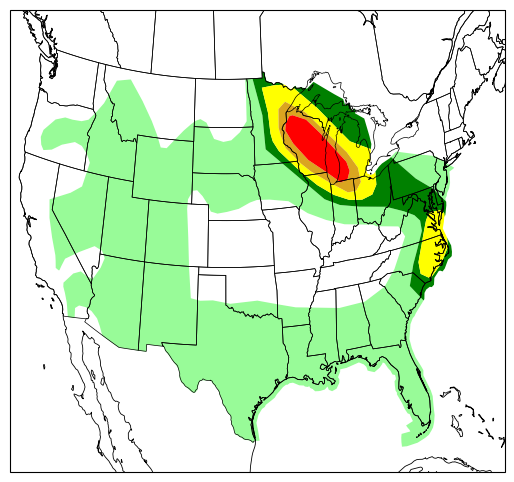

In [61]:
fig = plt.figure(1, figsize=(8,6))
ax = plt.subplot(projection=map_crs)
ax.set_extent([-120, -74, 22, 51])
ax.add_feature(cfeature.STATES, linewidth=0.5)
ax.add_feature(cfeature.COASTLINE, linewidth=0.6)

if gdf.empty:
    logging.warning(f"no {idate}")
else:
    for key in cat_plot_colors.keys():
        geometries = gdf[gdf[column].eq(key)]
        if len(geometries)>0:
            geometries.plot(ax=ax, color=cat_plot_colors[key], transform=ccrs.PlateCarree(), legend=True)

In [62]:
def make_map(bbox, projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(figsize=(16, 9),
            subplot_kw=dict(projection=projection))
    ax.set_extent(bbox)
    ax.add_feature(cfeature.BORDERS.with_scale('50m'), linewidth=0.25)
    ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.25)
    ax.add_feature(cfeature.STATES.with_scale('50m'), linewidth=0.05)
    ax.add_feature(cfeature.LAKES.with_scale('50m'), edgecolor='k', linewidth=0.25, facecolor='k', alpha=0.05)
    gl = ax.gridlines(draw_labels=True)
    gl.top_labels = gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    return fig, ax

In [63]:
from awips.dataaccess import DataAccessLayer
if False:
    DataAccessLayer.changeEDEXHost("edex-cloud.unidata.ucar.edu")
    request = DataAccessLayer.newDataRequest()
    request.setDatatype("grid")
    request.setLocationNames("LAMP2p5")
    request.setParameters("PROLGHT2hr")
    #request.setLevels("2.0FHAG")

    # Take a look at our request
    print(request)

    grid_locations = DataAccessLayer.getAvailableLevels(request)
    grid_locations.sort()
    list(grid_locations)

    cycles = DataAccessLayer.getAvailableTimes(request, True)
    times = DataAccessLayer.getAvailableTimes(request)
    fcstRun = DataAccessLayer.getForecastRun(cycles[-1], times)

    # Get the most recent grid data
    response = DataAccessLayer.getGridData(request, [fcstRun[0]])

    print('Number of available times:', len(times))
    print('Number of available forecast runs:', len(fcstRun))

    grid = response[0]
    data = grid.getRawData()
    lons, lats = grid.getLatLonCoords()
    bbox = [lons.min(), lons.max(), lats.min(), lats.max()]

    data[data == -999999] = np.nan
    data.min()
    np.nanmin(data)

DefaultDataRequest(datatype=grid, identifiers={}, parameters=['PROLGHT2hr'], levels=[], locationNames=['LAMP2p5'], envelope=None)
Number of available times: 28
Number of available forecast runs: 14


0.0

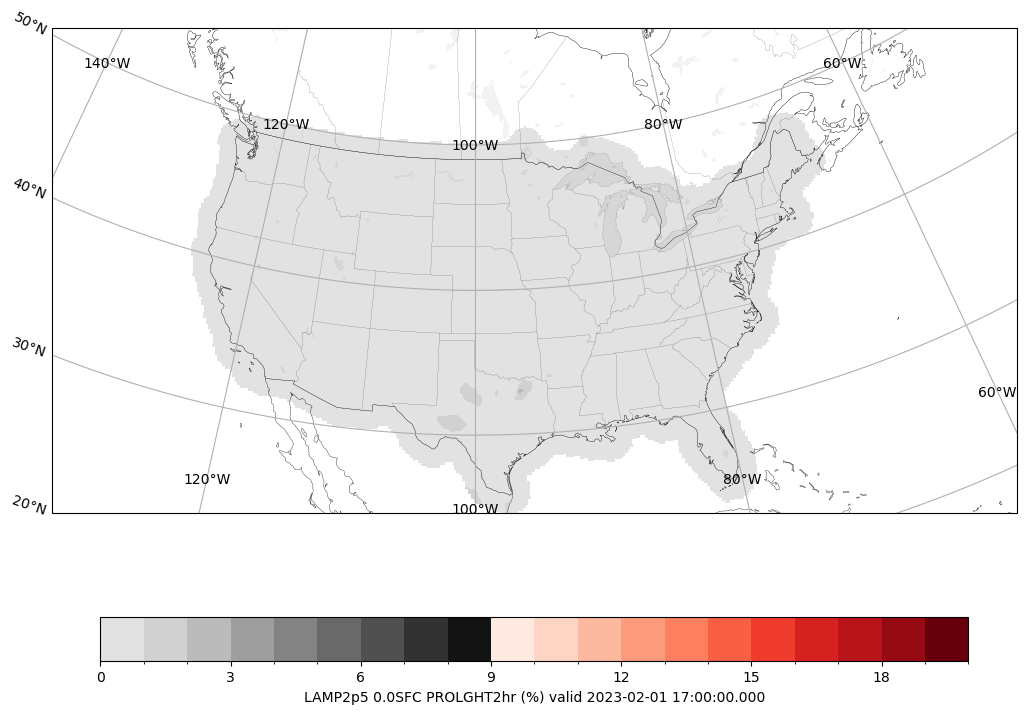

In [64]:
import nclcmaps
cmap = plt.get_cmap('rainbow')
from matplotlib.colors import ListedColormap, BoundaryNorm
test = nclcmaps.colors['MPL_Greys'][25::] + [[.99,.99,.99]] + nclcmaps.colors['MPL_Reds'][6::]
cmap = ListedColormap(test, "GreysReds")
norm = BoundaryNorm(np.arange(0,21,1), ncolors=cmap.N, clip=True)

fig, ax = make_map(bbox=bbox, projection = map_crs)
cs = ax.pcolormesh(lons, lats, data, cmap=cmap, norm=norm, transform=ccrs.PlateCarree())
cbar = fig.colorbar(cs, shrink=0.7, orientation='horizontal')
cbar.set_label(grid.getLocationName() +" "+ grid.getLevel() + " " \
               + grid.getParameter() + " (" + grid.getUnit() + ") " \
               + "valid " + str(grid.getDataTime().getRefTime()))

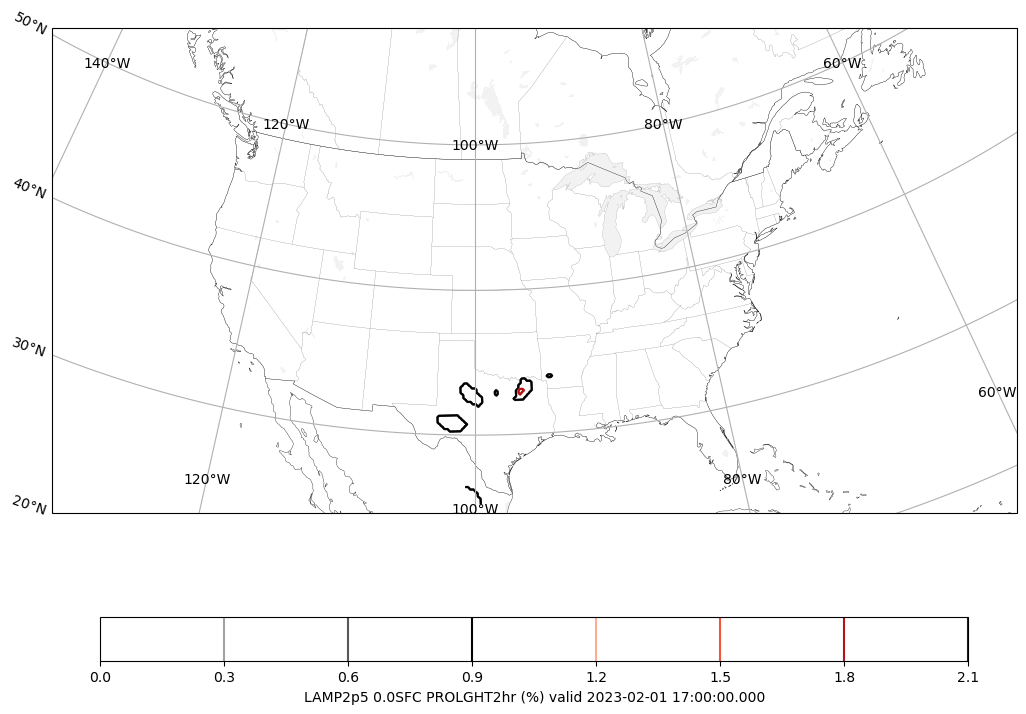

In [65]:
fig2, ax2 = make_map(bbox=bbox, projection=map_crs)
cs2 = ax2.contour(lons, lats, data, 80, cmap=cmap, levels=6,
                  transform=ccrs.PlateCarree(),
                  vmin=np.nanmin(data), vmax=np.nanmax(data))
cbar2 = fig2.colorbar(cs2, shrink=0.7, orientation='horizontal')
cbar2.set_label(grid.getLocationName() +" "+ grid.getLevel() + " " \
               + grid.getParameter() + " (" + grid.getUnit() + ") " \
               + "valid " + str(grid.getDataTime().getRefTime()))

In [66]:
from ml_functions import configs_match, get_argparser, get_features, get_savedmodel_path, load_df, rptdist2bool
from sklearn.model_selection import KFold
from tensorflow.keras.models import load_model
import yaml

In [67]:
idate_round = pd.to_datetime(idate).floor("D")
#idate_round = pd.to_datetime("20210601")
idate_round

Timestamp('2021-07-28 00:00:00')

In [68]:
parser = get_argparser()
args = parser.parse_args(args="--model HRRR --batchsize 1024 --neurons 1024 --optim sgd"
                         " --trainstart 19700101 --trainend 20201202 --teststart 20201202T12"
                         " --glm --flash 2"
                         " --testend 20220101 --epochs 10 --learning 0.001 --kfold 1".split())
setattr(args, "idate", idate_round) 
df = load_df(args)

In [69]:
args

Namespace(batchnorm=False, batchsize=1024, clobber=False, debug=False, dropout=0.0, epochs=10, event=None, fhr=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48], fits=None, flash=2, folds=None, glm=True, kfold=1, idate=Timestamp('2021-07-28 00:00:00'), ifile=None, learning_rate=0.001, model='HRRR', neurons=[1024], nfits=5, nprocs=0, optimizer='sgd', reg_penalty=0.01, rptdist=40, savedmodel=None, seed=None, trainend=Timestamp('2020-12-02 00:00:00'), trainstart=Timestamp('1970-01-01 00:00:00'), testend=Timestamp('2022-01-01 00:00:00'), teststart=Timestamp('2020-12-02 12:00:00'), suite='default', twin=2)

In [70]:
savedmodel = get_savedmodel_path(args, odir="nn/wbug")
savedmodel

'nn/wbug/HRRR.default.02flash.rpt_40km_2hr.1024n.ep10.f01-f48.bs1024.SGD.L20.01.lr0.001.dr0.0'

In [71]:
df, label_cols = rptdist2bool(df, args)

In [72]:
feature_list = get_features(args)

beforedropna = len(df)
logging.info(
    f"Retain rows where all {len(feature_list)} requested features are present")
df = df.dropna(axis="index", subset=feature_list)
logging.info(f"kept {len(df)}/{beforedropna} cases with no NA features")

columns_before_filtering = df.columns
df = df[feature_list]
logging.info(
    f"dropped {set(columns_before_filtering) - set(df.columns)}")
logging.info(
    f"kept {len(df.columns)}/{len(columns_before_filtering)} features")

In [73]:
y_preds = pd.DataFrame()
for ifold in range(args.kfold):
    for thisfit in range(args.nfits):
        savedmodel_thisfitfold = f"{savedmodel}_{thisfit}/{args.kfold}fold{ifold}"
        yl = yaml.load(open(
            os.path.join(savedmodel_thisfitfold, "config.yaml"), "r"),
            Loader=yaml.Loader)
        labels = yl["labels"]
        # delete labels so we can make DataFrame from rest of dictionary.
        del (yl["labels"])
        del (yl["args"])
        # scaling values DataFrame as from .describe()
        sv = pd.DataFrame(yl).set_index("columns").T
        if sv.columns.size != df.columns.size:
            logging.error(
                f"size of yaml and features columns differ {sv.columns} {df.columns}"
            )
        assert all(
            sv.columns == df.columns
        ), f"columns {df.columns} don't match when model was trained {sv.columns}"

        logging.info(f"loading {savedmodel_thisfitfold}")
        model = load_model(
            savedmodel_thisfitfold)
        norm_features = (df - sv.loc["mean"]) / sv.loc["std"]
        # Grab numpy array of predictions.
        Y = model.predict(norm_features.to_numpy(dtype='float32'), batch_size=10000)
        Y = pd.DataFrame(Y, columns=labels, index=df.index)
        # prepend "fit" level to multilevel DataFrame
        Y = pd.concat([Y], keys=[thisfit], names=["fit"])
        # prepend "fold" level
        Y = pd.concat([Y], keys=[ifold], names=["fold"])
        # concatenate this fit/fold to the y_preds DataFrame
        y_preds = pd.concat([y_preds, Y], axis="index")

7/7 [==============================] - 0s 32ms/step


In [74]:
# I may have overlapping valid_times from different init_times like fhr=1 from today and fhr=25 from previous day
# average probability over all nfits initialized at initialization_time and valid at valid_time
ensmean = y_preds.groupby(level=[
    "valid_time", "y", "x"
]).mean()
assert "fit" not in ensmean.index.names, "fit should not be a MultiIndex level of ensmean, the average probability over nfits."

In [75]:
ensmean

sighail_40km_2hr  sigwind_40km_2hr  \
valid_time          y  x                                        
2021-07-28 01:00:00 21 33          0.000026          0.000036   
                       34          0.000026          0.000036   
                       35          0.000021          0.000029   
                       36          0.000018          0.000025   
                    22 29          0.000016          0.000022   
...                                     ...               ...   
2021-07-30 00:00:00 79 41          0.000030          0.000042   
                       42          0.000040          0.000057   
                       43          0.000042          0.000059   
                       44          0.000036          0.000049   
                    80 41          0.000027          0.000036   

                           hailone_40km_2hr  wind_40km_2hr  torn_40km_2hr  \
valid_time          y  x                                                    
2021-07-28 01:00:00 21 33          0.000108       0.000336       0.000038   
                       34          0.000109       0.000347       0.000038   
                       35          0.000087       0.000267       0.000031   
                       36          0.000075       0.000218       0.000027   
                    22 29          0.000066       0.000173       0.000023   
...                                     ...            ...            ...   
2021-07-30 00:00:00 79 41          0.000115       0.000365       0.000045   
                       42          0.000161       0.000527       0.000061   
                       43          0.000170       0.000537       0.000063   
                       44          0.000144       0.000433       0.000052   
                    80 41          0.000101       0.000313       0.000039   

                           any_40km_2hr  cg_40km_2hr  ic_40km_2hr  \
valid_time          y  x                                            
2021-07-28 01:00:00 21 33      0.000394     0.007416     0.010146   
                       34      0.000407     0.008798     0.011941   
                       35      0.000312     0.005320     0.007277   
                       36      0.000254     0.003573     0.004869   
                    22 29      0.000205     0.001695     0.002235   
...                                 ...          ...          ...   
2021-07-30 00:00:00 79 41      0.000425     0.004328     0.005285   
                       42      0.000620     0.008410     0.010405   
                       43      0.000636     0.009623     0.012225   
                       44      0.000513     0.007286     0.009293   
                    80 41      0.000361     0.003544     0.004421   

                           cg.ic_40km_2hr  flashes_40km_2hr  
valid_time          y  x                                     
2021-07-28 01:00:00 21 33        0.010833          0.011227  
                       34        0.012848          0.013342  
                       35        0.007775          0.008073  
                       36        0.005172          0.005390  
                    22 29        0.002352          0.002473  
...                                   ...               ...  
2021-07-30 00:00:00 79 41        0.005754          0.006222  
                       42        0.011360          0.012220  
                       43        0.013237          0.014121  
                       44        0.010005          0.010614  
                    80 41        0.004777          0.005139  

[62784 rows x 10 columns]

<GeoAxesSubplot: xlabel='lon', ylabel='lat'>

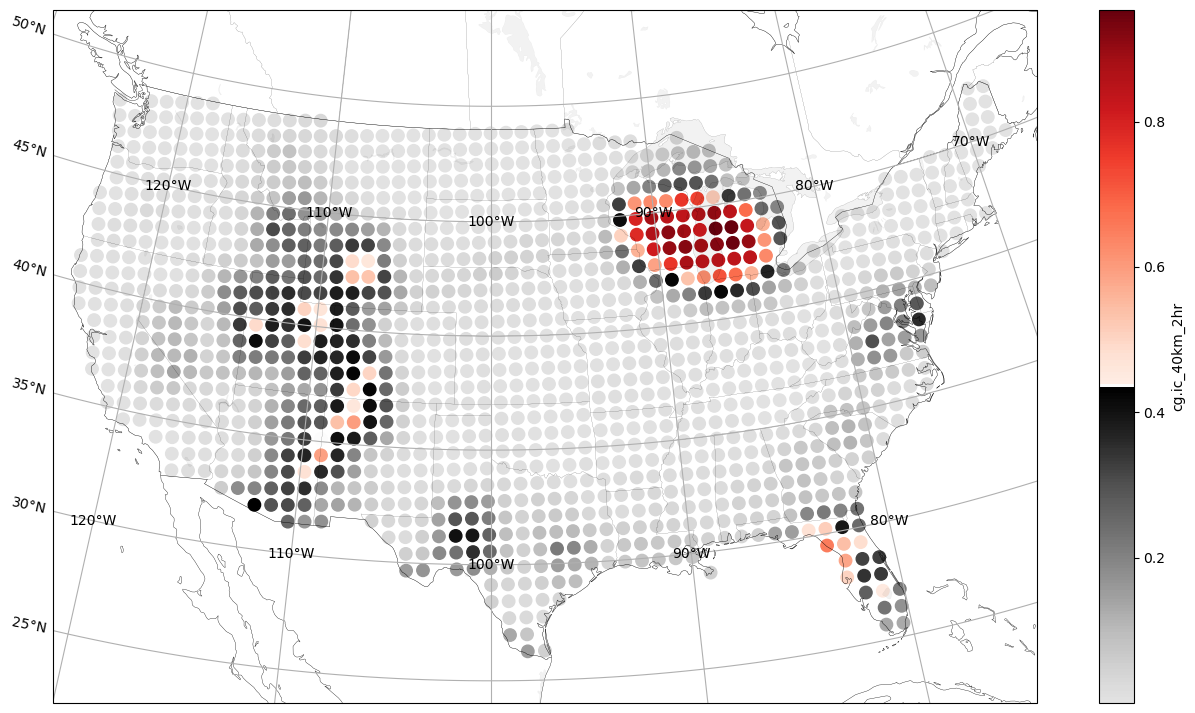

In [117]:
bbox2 = [-120, -75, 22, 52]
fig, ax = make_map(bbox=bbox2, projection=map_crs)
f = "cg.ic"
f += f"_{args.rptdist}km_{args.twin}hr"

# add to df so we can use df's lat and lon for coordinates.
df[f] = ensmean[f]
valid_times = ensmean.index.get_level_values("valid_time")
df.xs(idate+datetime.timedelta(hours=9), level="valid_time").plot(ax=ax, cmap=cmap,
                                                   kind="scatter",x="lon",y="lat",c=f,
                                                   s=80, marker="o",
                                                   transform=ccrs.PlateCarree())

KeyboardInterrupt: 

In [105]:
import seaborn as sns
df[f].groupby("valid_time").plot(x="lon",y="lat", kind="scatter",
                                                   s=80, marker="o",
                                                   transform=ccrs.PlateCarree())

ValueError: plot kind scatter can only be used for data frames

In [ ]:
pd.concat([features[["lat","lon"]], Y.groupby(["y","x"]).mean()])

In [ ]:
pd.__version__

In [ ]:
np.array(test).shape

In [ ]:
from matplotlib.colors import LinearSegmentedColormap
cmap = LinearSegmentedColormap.from_list("GreysReds", test)

In [ ]:
cmap

In [ ]:
from importlib import reload

In [ ]:
reload(pd)